In [2]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns


####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2

    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot

    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys

    def old_boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]


        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys


    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        dof = np.array([12])
        return M, dof, Mphys


    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.

        return [np.array([v,self.u])]

    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and self.lammix<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False


    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")

    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0.
        Doesn't work for Z_2 symmetric potential!!!"""
        n=100
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True \n")
            return True
        #------------
        X0=self.findMinimum([0,100],0)
        if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
        X0=self.findMinimum([0,-100],0)
        if m.Vtot(X0,0)<=m.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
         
        ###This loop search for a global minima randomly
        for i in range(n):
            x1=np.random.uniform(-100,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(X0[0])-v>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1e2:
                print("Global minimum found at X=",X0,"\n")
                print("isEWSB=False \n")
                return False
        print("isEWSB=True \n")
        return True




def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum
    ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity



def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restored at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"

    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR


   

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Compute the transition of model(s)

In [4]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0]).sort_values("alpha_max")
df=df[df["alpha_max"]>1e-2]



#np.random.seed()
#modi=np.random.randint(0,len(df))
modi=-1
ms_val=df.iloc[modi]["ms"]
theta_val=df.iloc[modi]["theta"]
u_val=df.iloc[modi]["u"]
mu3_val=df.iloc[modi]["mu3"]
muhs_val=df.iloc[modi]["muhs"]

#m=model1(ms = ms_val*(1+np.random.uniform(-.05,0.05)), 
#         theta = theta_val*(1+np.random.uniform(-.05,0.05)),
#         muhs= muhs_val*(1+np.random.uniform(-.05,0.05)) ,
#         u = u_val*(1+np.random.uniform(-.05,0.05)),
#         mu3 = mu3_val*(1+np.random.uniform(-.05,0.05)))

m=model1(ms = ms_val, theta = theta_val,muhs= muhs_val ,u = u_val,mu3 = mu3_val)

m.print_couplings()
thbool=m.theory_consistent()
EWSBbool=m.isEWSB()

Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
Pis=m.lammix/6 + m.lams/4
lamh_tilde=m.lamh - m.lammix**2/4/m.lams
dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,
      "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
      "muh2":m.muh2,"mus2":m.mus2,
      "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
dict_out.update({ "th_bool":thbool and EWSBbool})
if thbool==True and EWSBbool==True:
    try:
        alltrans=m.findAllTransitions()
        index=0
        count_trans=0
        alpha_list=[]
        dT_list=[]
        trans_types=[]
        for elem in alltrans:
            if elem["trantype"]==1:
                count_trans+=1
                phi_stable=elem["low_vev"]
                phi_meta=elem["high_vev"]
                SymNR=np.sum(m.findMinimum([0,0],1000)**2)**0.5>10
                dh,ds=abs(phi_meta-phi_stable)
                trans_types.append(trans_class(SymNR))
                Tnuc=elem["Tnuc"]
                #Tc=elem["Tcrit"]
                dT=abs(m.phases[elem["high_phase"]].T[0]-m.phases[elem["low_phase"]].T[-1])
                dT_list.append(dT)
                Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
                alpha=alpha_GW(Tnuc,Delta_rho)
                alpha_list.append(alpha)
                Delta_pressure=m.Vtot(phi_meta,Tnuc) -m.Vtot(phi_stable,Tnuc)
                vwformula=(Delta_pressure/Delta_rho)**0.5
                xi_Jouguet=((alpha*(2+3*alpha))**0.5+1)/(3**0.5*(1+alpha))
                v_calculable=vwformula<xi_Jouguet
                dict_out.update({ "h_low_"+str(index):phi_stable[0],"s_low_"+str(index):phi_stable[1],
                                 "h_high_"+str(index):phi_meta[0],"s_high_"+str(index):phi_meta[1],
                                 "Tnuc_"+str(index):Tnuc,"dT_"+str(index):dT,"alpha_"+str(index):alpha,
                                "vwf_"+str(index):vwformula,"xi_J_"+str(index):xi_Jouguet,
                                 "v_calculable_"+str(index):vwformula<xi_Jouguet})
                index+=1
        relevant_index=alpha_list.index(max(alpha_list))
        dict_out.update({"num_FOPT":count_trans,"alpha_max":max(alpha_list),
                         "dT_max":dT_list[relevant_index],
                         "tran_type":trans_types[relevant_index]})

    except:
        print("error ocurred")

Potential parameters are given by 
 
mus2= 97048.78276579916 muh2= -106921.25868784786 lamh= 0.3606186174886081 lams= 6.802467076016097 lammix= 0.992297612044979 

Model parameters are 

ms= 776.0610982085018 theta= -0.22052942967644606 muhs= 717.1025440708265 u= -210.1348312328784 mu3= -618.523047503145 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [ 246.20000203 -210.13483225] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.....................................................................................................................................
Tracing phase starting at x = [ 2.18871925e-06 -1.67545811e+02] ; t = 115.17930124482866
Tracing minimum down
traceMinimum t0 = 115.179
...........................
Tracing minimum up
traceMinimum t0 = 115.179
..............................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 21 steps. fRatio = 1.30266e-02
Path deformation converged. 1 steps. fRatio = 6.24627e-02


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Tunneling from phase 1 to phase 0 at T=50.50548
high_vev = [-4.16914834e-05 -1.65847007e+02]
low_vev = [ 244.25320715 -209.71122015]
Path deformation converged. 20 steps. fRatio = 3.76739e-03
Path deformation converged. 1 steps. fRatio = 3.34932e-02
Tunneling from phase 1 to phase 0 at T=74.52589
high_vev = [ 7.44066590e-07 -1.66403679e+02]
low_vev = [ 236.62576995 -208.05427831]
Path deformation converged. 19 steps. fRatio = 6.81638e-03
Path deformation converged. 1 steps. fRatio = 3.62757e-02
Tunneling from phase 1 to phase 0 at T=50.56672
high_vev = [-4.39142784e-05 -1.65848184e+02]
low_vev = [ 244.24291601 -209.70898279]
Path deformation converged. 20 steps. fRatio = 3.76093e-03
Path deformation converged. 1 steps. fRatio = 3.35363e-02
Tunneling from phase 1 to phase 0 at T=62.54631
high_vev = [-4.70531736e-05 -1.66104031e+02]
low_vev = [ 241.4278908  -209.09726125]
Path deformation converged. 19 steps. fRatio = 1.44570e-02
Path deformation converged. 1 steps. fRatio = 3.59030e-02


In [5]:
dict_out

{'ms': 776.0610982085018,
 'theta': -0.22052942967644606,
 'u': -210.1348312328784,
 'muhs': 717.1025440708265,
 'mu3': -618.523047503145,
 'lamh': 0.3606186174886081,
 'lams': 6.802467076016097,
 'lammix': 0.992297612044979,
 'muh2': -106921.25868784786,
 'mus2': 97048.78276579916,
 'Pih': 0.5561565244915884,
 'Pis': 1.865999704344854,
 'lamh_tilde': 0.32443121151270016,
 'th_bool': True,
 'h_low_0': 243.93213548527507,
 's_low_0': -209.64142333683662,
 'h_high_0': -4.37316277256703e-05,
 's_high_0': -165.88250338474498,
 'Tnuc_0': 52.32139562484818,
 'dT_0': 114.17753298420018,
 'alpha_0': 0.21015666563056362,
 'vwf_0': 0.9196326552798221,
 'xi_J_0': 0.8318075060625947,
 'v_calculable_0': False,
 'num_FOPT': 1,
 'alpha_max': 0.21015666563056362,
 'dT_max': 114.17753298420018,
 'tran_type': 'hs-SNR'}

In [44]:
df.iloc[modi]

ms                776.061
theta           -0.220529
u                -210.135
muhs              717.103
mu3              -618.523
lamh             0.360619
lams              6.80247
lammix           0.992298
muh2              -106921
mus2              97048.8
Pih              0.556157
Pis                 1.866
lamh_tilde       0.324431
th_bool              True
h_low_0           243.932
s_low_0          -209.641
h_high_0     -5.70305e-05
s_high_0         -165.883
Tnuc_0            52.3215
dT_0              114.178
alpha_0          0.210154
num_FOPT                1
alpha_max        0.210154
dT_max            114.178
tran_type          hs-SNR
h_low_1               NaN
s_low_1               NaN
h_high_1              NaN
s_high_1              NaN
Tnuc_1                NaN
dT_1                  NaN
alpha_1               NaN
h_low_2               NaN
s_low_2               NaN
h_high_2              NaN
s_high_2              NaN
Tnuc_2                NaN
dT_2                  NaN
alpha_2     

In [45]:
m.calcTcTrans()

[{'Tcrit': 98.54630331661052,
  'high_vev': array([-5.79151681e-05, -1.67078847e+02]),
  'high_phase': 1,
  'low_vev': array([ 216.8568958 , -203.75821343]),
  'low_phase': 0,
  'trantype': 1,
  'Delta_rho': 32019860.100898743}]

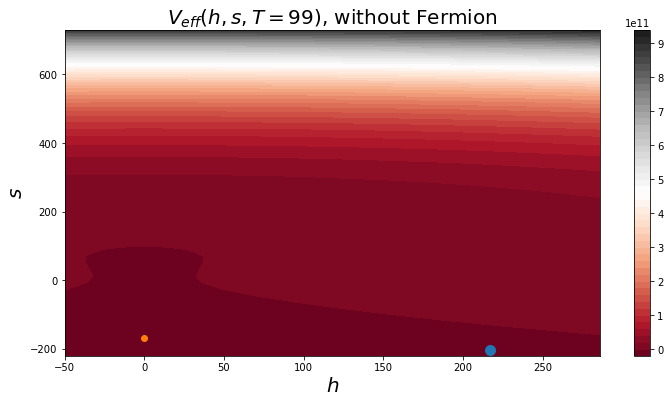

In [46]:
clevs=50
myN = 50
Temp=m.TcTrans[0]["Tcrit"]

X_1=m.findMinimum([df.iloc[modi].h_low_0,df.iloc[modi].s_low_0],Temp)##EW minimum
X_2=m.findMinimum([df.iloc[modi].h_high_0,df.iloc[modi].s_high_0],Temp) 


box=(-50,v+40,520-m.u-np.sign(m.u)*0,m.u+np.sign(m.u)*10)
#box=(-10,v+50,120,210)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + "), without Fermion",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
fig.colorbar(cf1, ax=ax1)
ax1.scatter(X_1[0],X_1[1],s=100)
ax1.scatter(X_2[0],X_2[1])
plt.show()

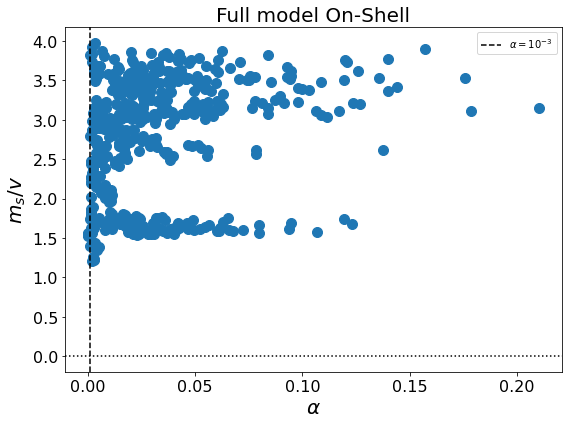

In [3]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0]).sort_values("alpha_max")
#df=df[df["alpha_max"]>9*1e-3]


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.ms/v,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
plt.axhline(y=0,linestyle=":",color="k")
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$m_s/v$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=6)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

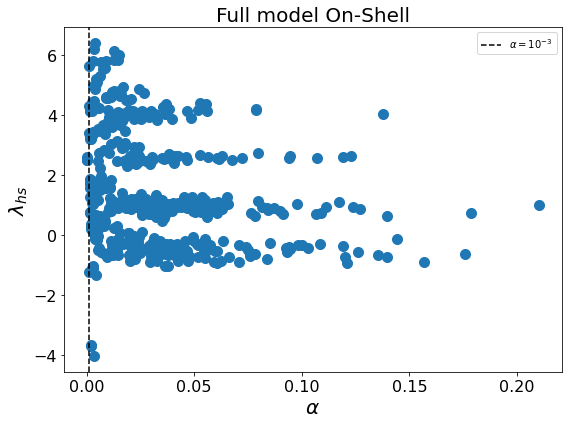

In [4]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
#df=df[df["alpha_max"]>5*1e-2]


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.lammix,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\lambda_{hs}$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

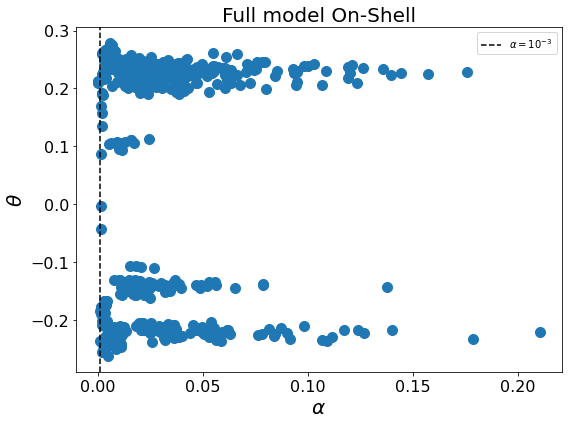

In [5]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
#df=df[df["alpha_max"]>9*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.theta,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\theta$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

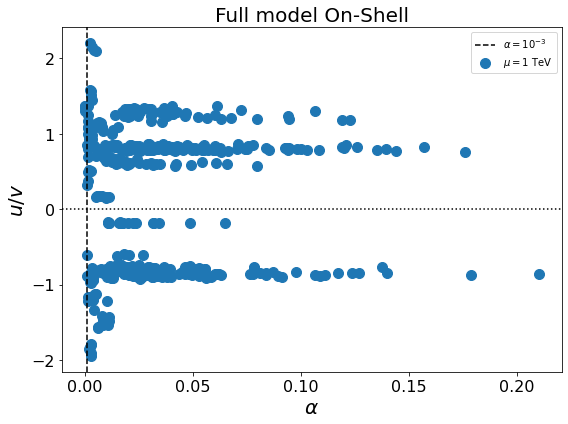

In [6]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
#df=df[df["alpha_max"]>6*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.u/v,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
plt.axhline(y=0,linestyle=":",color="k")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$u/v$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

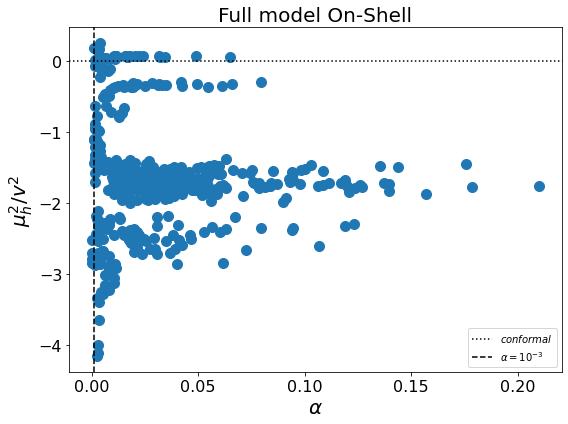

In [13]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
#df=df[df["alpha_max"]>6*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.muh2/v**2,s=100)
plt.axhline(y=0,linestyle=":",color="k",label="$conformal$")
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\mu_{h}^2/v^2$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

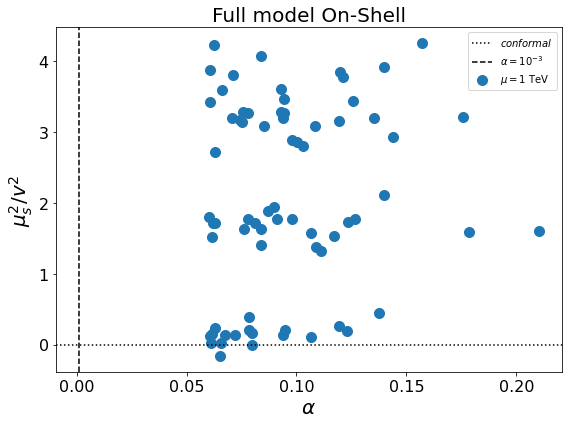

In [8]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
df=df[df["alpha_max"]>6*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.mus2/v**2,label="$\\mu= 1$ TeV",s=100)
plt.axhline(y=0,linestyle=":",color="k",label="$conformal$")
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\mu_{s}^2/v^2$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

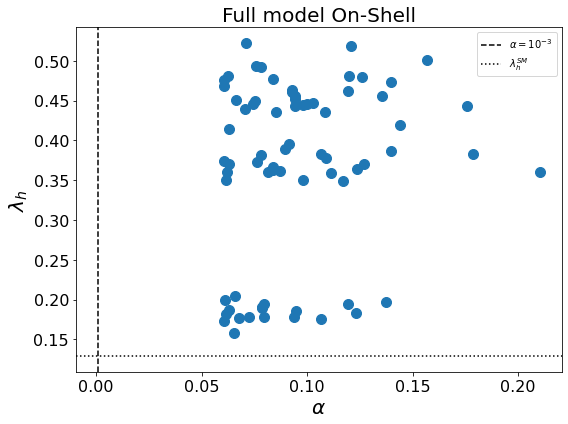

In [9]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
df=df[df["alpha_max"]>6*1e-2]


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.lamh,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
plt.axhline(y=mh**2/2/v**2,linestyle=":",color="k",label="$\\lambda_{h}^{SM}$")
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\lambda_h$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

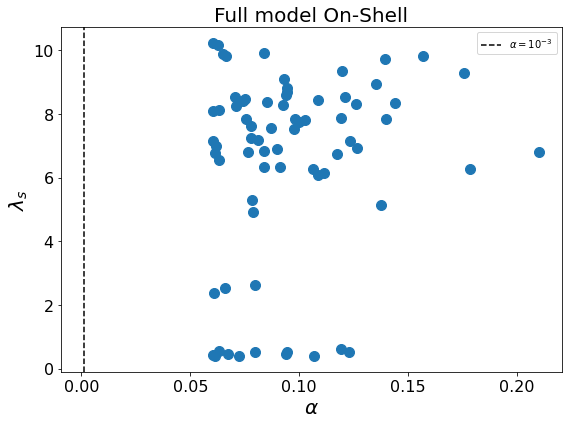

In [10]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
df=df[df["alpha_max"]>6*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.lams,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\lambda_s$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

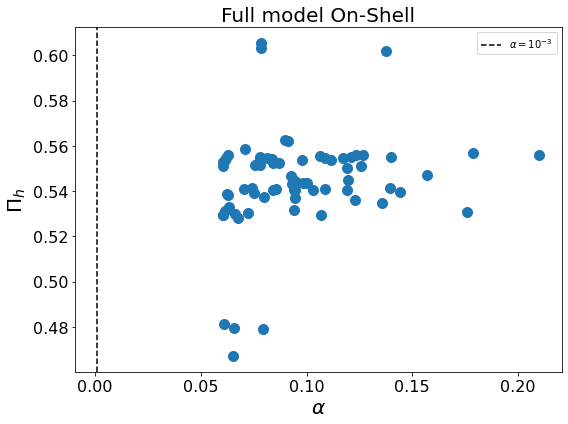

In [11]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
df=df[df["alpha_max"]>6*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.Pih,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\Pi_h$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


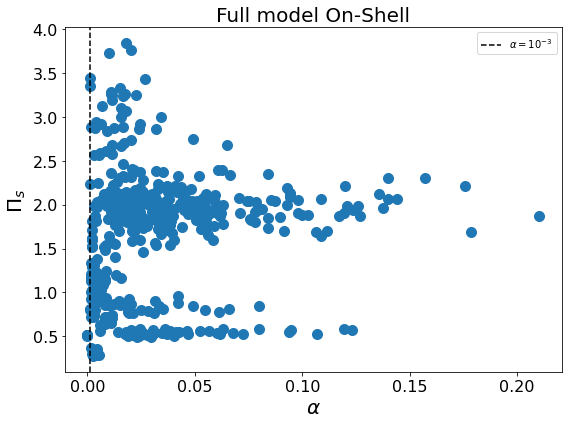

In [3]:
df=pd.read_csv("./SCANS/On_Shell_STRONG.csv",index_col=[0])
#df=df[df["alpha_max"]>6*1e-2]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df.alpha_max,df.Pis,s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\Pi_s$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

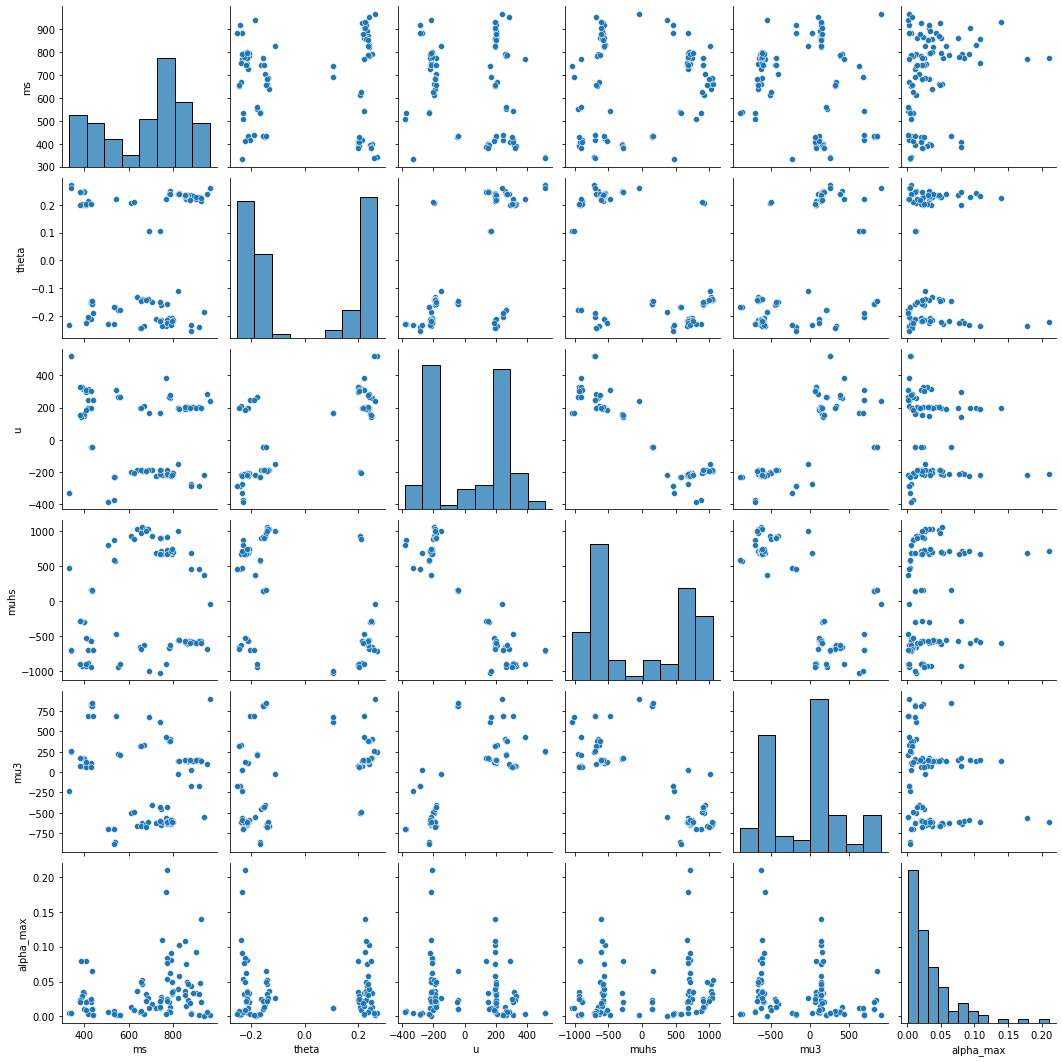

In [14]:
sns.pairplot(df[['ms', 'theta', 'u','muhs', 'mu3',"alpha_max"]].reset_index(drop=True).sample(100))